**Implement a model that predicts which customers make at least 1 purchase in a given month using features generated from the 2 previous months.**

**Loading libraries**

In [4]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import sklearn
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


**Uploading data to google drive**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving VinIDRecruitChallenge_MLTrack_DataSet.csv to VinIDRecruitChallenge_MLTrack_DataSet.csv


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [5]:
df = pd.read_csv('VinIDRecruitChallenge_MLTrack_DataSet.csv')
print('=================================================')
print('=================================================')
print('df.head',df.head())
print('=================================================')
print('=================================================')
print('df.info',df.info())
print('=================================================')
print('=================================================')
print('df.shape',df.shape)
print('=================================================')
print('=================================================')

df.head             csn        date                                   transaction_info
0  Y2NgaWJoYw==  2018-03-02  [{'article': '10020163', 'salesquantity': 2.0,...
1  Y2NgaWJoYw==  2018-03-04  [{'article': '10026562', 'salesquantity': 3.0,...
2  Y2NgaWlpYA==  2018-02-27  [{'article': '10013531', 'salesquantity': 1.0,...
3  Y2NgaWlpYA==  2018-03-16  [{'article': '10008991', 'salesquantity': 1.0,...
4  Y2NgaWlpYA==  2018-05-24  [{'article': '10009698', 'salesquantity': 1.0,...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131794 entries, 0 to 131793
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   csn               131794 non-null  object
 1   date              131794 non-null  object
 2   transaction_info  131794 non-null  object
dtypes: object(3)
memory usage: 3.0+ MB
df.info None
df.shape (131794, 3)


****

**Parsing json format**

In [6]:
#for i in range(df.shape[0]):
#    df['transaction_info'][i] = json.loads(df['transaction_info'][i].replace('\'','\"'))
#    #if i % 10000 == 0:  print(i)

df['transaction_info'] = df['transaction_info'].apply(lambda x: json.loads(x.replace('\'','\"')))

df = df.to_json(orient="records")
df = json.loads(df)
df = pd.json_normalize(df,'transaction_info',['csn','date'])    

print('=================================================')
print('=================================================')
print('df.head',df.head())
print('=================================================')
print('=================================================')
print('df.info',df.info())
print('=================================================')
print('=================================================')
print('df.shape',df.shape)
print('=================================================')
print('=================================================')

df.date=pd.to_datetime(df.date, format='%Y-%m-%d')

#df.date.hist()

print('df.describe',df.describe(include = 'all'))
print('=================================================')
print('=================================================')
# article unique     19359
# csn     unique     20000
# 993512 article from 2018-02-01 to 2018-06-30
df.to_csv('df_after_parse_json_format.csv')

df.head     article  salesquantity    price           csn        date
0  10020163            2.0  18250.0  Y2NgaWJoYw==  2018-03-02
1  10026562            3.0  13000.0  Y2NgaWJoYw==  2018-03-04
2  10320883            2.0  43000.0  Y2NgaWJoYw==  2018-03-04
3  10013531            1.0  17800.0  Y2NgaWlpYA==  2018-02-27
4  10015613            1.0   5600.0  Y2NgaWlpYA==  2018-02-27
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993512 entries, 0 to 993511
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   article        993512 non-null  object 
 1   salesquantity  993512 non-null  float64
 2   price          993512 non-null  float64
 3   csn            993512 non-null  object 
 4   date           993512 non-null  object 
dtypes: float64(2), object(3)
memory usage: 37.9+ MB
df.info None
df.shape (993512, 5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


df.describe          article  salesquantity         price       csn                 date
count     993512  993512.000000  9.935120e+05    993512               993512
unique     19359            NaN           NaN     20000                  147
top     10083185            NaN           NaN  ZGZobWZq  2018-02-11 00:00:00
freq       11454            NaN           NaN      1184                17585
first        NaN            NaN           NaN       NaN  2018-02-01 00:00:00
last         NaN            NaN           NaN       NaN  2018-06-30 00:00:00
mean         NaN       2.453600  5.847608e+04       NaN                  NaN
std          NaN     123.067588  8.675746e+04       NaN                  NaN
min          NaN       0.002000  1.666700e+02       NaN                  NaN
25%          NaN       0.624000  1.410000e+04       NaN                  NaN
50%          NaN       1.000000  3.200000e+04       NaN                  NaN
75%          NaN       1.042000  6.780000e+04       NaN         

**Creating year_month and amount columns**

In [7]:
df.date=pd.to_datetime(df.date, format='%Y-%m-%d')
df['year_month'] = df['date'].apply(lambda x:  int(str(x.year) + '0' + str(x.month)))
print(df['year_month'].value_counts())
#df.head()
df['amount'] = df['salesquantity']*df['price']
print(df.columns)

201802    219691
201805    195016
201806    194955
201803    192263
201804    191587
Name: year_month, dtype: int64
Index(['article', 'salesquantity', 'price', 'csn', 'date', 'year_month',
       'amount'],
      dtype='object')


**Feature based on transactions last 1 month**

In [8]:
salesquantity_feature_last_1m = df.groupby(['csn','year_month'])['salesquantity'].agg([('sum_salesquantity',np.sum),('min_salesquantity',np.min),('median_salesquantity',np.median),('mean_salesquantity',np.mean),('max_salesquantity',np.max),('std_salesquantity',np.std), ('count_salesquantity','count')]).reset_index()
price_feature_last_1m = df.groupby(['csn','year_month'])['price'].agg([('sum_price',np.sum),('min_price',np.min),('median_price',np.median),('mean_price',np.mean),('max_price',np.max),('std_price',np.std)]).reset_index()
amount_feature_last_1m = df.groupby(['csn','year_month'])['amount'].agg([('sum_amount',np.sum),('min_amount',np.min),('median_amount',np.median),('mean_amount',np.mean),('max_amount',np.max),('std_amount',np.std)]).reset_index()
feature_last_1m = pd.merge(salesquantity_feature_last_1m,price_feature_last_1m,on=['csn','year_month'],how='left')
feature_last_1m = pd.merge(feature_last_1m,amount_feature_last_1m,on=['csn','year_month'],how='left')
feature_last_1m = feature_last_1m.rename(columns=lambda s: s + '_last_1m')
feature_last_1m = feature_last_1m.rename(columns={'csn_last_1m':'csn','year_month_last_1m':'year_month'})
print(feature_last_1m.columns)


Index(['csn', 'year_month', 'sum_salesquantity_last_1m',
       'min_salesquantity_last_1m', 'median_salesquantity_last_1m',
       'mean_salesquantity_last_1m', 'max_salesquantity_last_1m',
       'std_salesquantity_last_1m', 'count_salesquantity_last_1m',
       'sum_price_last_1m', 'min_price_last_1m', 'median_price_last_1m',
       'mean_price_last_1m', 'max_price_last_1m', 'std_price_last_1m',
       'sum_amount_last_1m', 'min_amount_last_1m', 'median_amount_last_1m',
       'mean_amount_last_1m', 'max_amount_last_1m', 'std_amount_last_1m'],
      dtype='object')


**Feature based on transactions last 2 months**

In [9]:
# base1 (predict do a purchase on apr2018): feature based on feb2018 and mar2018
salesquantity_feature_last_2m_base1 = df[(df.year_month == 201803) | (df.year_month == 201802)].groupby(['csn'])['salesquantity'].agg([('sum_salesquantity',np.sum),('min_salesquantity',np.min),('median_salesquantity',np.median),('mean_salesquantity',np.mean),('max_salesquantity',np.max),('std_salesquantity',np.std), ('count_salesquantity','count')]).reset_index()
price_feature_last_2m_base1 = df[(df.year_month == 201803) | (df.year_month == 201802)].groupby(['csn'])['price'].agg([('sum_price',np.sum),('min_price',np.min),('median_price',np.median),('mean_price',np.mean),('max_price',np.max),('std_price',np.std)]).reset_index()
amount_feature_last_2m_base1 = df[(df.year_month == 201803) | (df.year_month == 201802)].groupby(['csn'])['amount'].agg([('sum_amount',np.sum),('min_amount',np.min),('median_amount',np.median),('mean_amount',np.mean),('max_amount',np.max),('std_amount',np.std)]).reset_index()
feature_last_2m_base1 = pd.merge(salesquantity_feature_last_2m_base1,price_feature_last_2m_base1,on=['csn'],how='left')
feature_last_2m_base1 = pd.merge(feature_last_2m_base1,amount_feature_last_2m_base1,on=['csn'],how='left')
feature_last_2m_base1 = feature_last_2m_base1.rename(columns=lambda s: s + '_last_2m')
feature_last_2m_base1 = feature_last_2m_base1.rename(columns={'csn_last_2m':'csn'})

# base2 (predict do a purchase on may2018): feature based on mar2018 and apr2018

salesquantity_feature_last_2m_base2 = df[(df.year_month == 201804) | (df.year_month == 201803)].groupby(['csn'])['salesquantity'].agg([('sum_salesquantity',np.sum),('min_salesquantity',np.min),('median_salesquantity',np.median),('mean_salesquantity',np.mean),('max_salesquantity',np.max),('std_salesquantity',np.std), ('count_salesquantity','count')]).reset_index()
price_feature_last_2m_base2 = df[(df.year_month == 201804) | (df.year_month == 201803)].groupby(['csn'])['price'].agg([('sum_price',np.sum),('min_price',np.min),('median_price',np.median),('mean_price',np.mean),('max_price',np.max),('std_price',np.std)]).reset_index()
amount_feature_last_2m_base2 = df[(df.year_month == 201804) | (df.year_month == 201803)].groupby(['csn'])['amount'].agg([('sum_amount',np.sum),('min_amount',np.min),('median_amount',np.median),('mean_amount',np.mean),('max_amount',np.max),('std_amount',np.std)]).reset_index()
feature_last_2m_base2 = pd.merge(salesquantity_feature_last_2m_base2,price_feature_last_2m_base2,on=['csn'],how='left')
feature_last_2m_base2 = pd.merge(feature_last_2m_base2,amount_feature_last_2m_base2,on=['csn'],how='left')
feature_last_2m_base2 = feature_last_2m_base2.rename(columns=lambda s: s + '_last_2m')
feature_last_2m_base2 = feature_last_2m_base2.rename(columns={'csn_last_2m':'csn'})

# base3 (predict do a purchase on jun2018): feature based on apr2018 and may2018

salesquantity_feature_last_2m_base3 = df[(df.year_month == 201805) | (df.year_month == 201804)].groupby(['csn'])['salesquantity'].agg([('sum_salesquantity',np.sum),('min_salesquantity',np.min),('median_salesquantity',np.median),('mean_salesquantity',np.mean),('max_salesquantity',np.max),('std_salesquantity',np.std), ('count_salesquantity','count')]).reset_index()
price_feature_last_2m_base3 = df[(df.year_month == 201805) | (df.year_month == 201804)].groupby(['csn'])['price'].agg([('sum_price',np.sum),('min_price',np.min),('median_price',np.median),('mean_price',np.mean),('max_price',np.max),('std_price',np.std)]).reset_index()
amount_feature_last_2m_base3 = df[(df.year_month == 201805) | (df.year_month == 201804)].groupby(['csn'])['amount'].agg([('sum_amount',np.sum),('min_amount',np.min),('median_amount',np.median),('mean_amount',np.mean),('max_amount',np.max),('std_amount',np.std)]).reset_index()
feature_last_2m_base3 = pd.merge(salesquantity_feature_last_2m_base3,price_feature_last_2m_base3,on=['csn'],how='left')
feature_last_2m_base3 = pd.merge(feature_last_2m_base3,amount_feature_last_2m_base3,on=['csn'],how='left')
feature_last_2m_base3 = feature_last_2m_base3.rename(columns=lambda s: s + '_last_2m')
feature_last_2m_base3 = feature_last_2m_base3.rename(columns={'csn_last_2m':'csn'})

**Sampling **

In [10]:
#%%% Base1 (predict do a purchase on apr2018), Base2 (predict do a purchase on may2018), Base3 (predict do a purchase on jun2018), 

base1 = pd.DataFrame(df.csn[(df.year_month == 201803) | (df.year_month == 201802)].drop_duplicates())
base1['target'] = base1['csn'].isin(df.csn[df.year_month == 201804].drop_duplicates())
base1 = pd.merge(base1,feature_last_2m_base1,on=['csn'],how='left')
base1 = pd.merge(base1,feature_last_1m[feature_last_1m.year_month==201803],on=['csn'],how='left')
base1.year_month = 201803
print(base1.shape)
print('=================================================')
print('=================================================')
base2 = pd.DataFrame(df.csn[(df.year_month == 201804) | (df.year_month == 201803)].drop_duplicates())
base2['target'] = base2['csn'].isin(df.csn[df.year_month == 201805].drop_duplicates())
base2 = pd.merge(base2,feature_last_2m_base2,on=['csn'],how='left')
base2 = pd.merge(base2,feature_last_1m[feature_last_1m.year_month==201804],on=['csn'],how='left')
base2.year_month = 201804
print(base2.shape)
print('=================================================')
print('=================================================')
base3 = pd.DataFrame(df.csn[(df.year_month == 201805) | (df.year_month == 201804)].drop_duplicates())
base3['target'] = base3['csn'].isin(df.csn[df.year_month == 201806].drop_duplicates())
base3 = pd.merge(base3,feature_last_2m_base3,on=['csn'],how='left')
base3 = pd.merge(base3,feature_last_1m[feature_last_1m.year_month==201805],on=['csn'],how='left')
base3.year_month = 201805
print(base3.shape)
print('=================================================')
print('=================================================')

base_all = base1.append(base2) 
base_all = base_all.append(base3) 
base_all.to_csv('base_all.csv')
print('=================================================')
print('=================================================')
print(base_all.info())
print('=================================================')
print('=================================================')
print(base_all.year_month.value_counts())
print('=================================================')
print('=================================================')
print(base_all.shape)
print('=================================================')
print('=================================================')

print(base_all['target'].value_counts())
base_all['target'] = np.multiply(base_all['target'], 1)
print('=================================================')
print('=================================================')
print(base_all['target'].value_counts())
print('=================================================')
print('=================================================')

(13284, 41)
(12521, 41)
(12713, 41)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38518 entries, 0 to 12712
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   csn                           38518 non-null  object 
 1   target                        38518 non-null  bool   
 2   sum_salesquantity_last_2m     38518 non-null  float64
 3   min_salesquantity_last_2m     38518 non-null  float64
 4   median_salesquantity_last_2m  38518 non-null  float64
 5   mean_salesquantity_last_2m    38518 non-null  float64
 6   max_salesquantity_last_2m     38518 non-null  float64
 7   std_salesquantity_last_2m     36928 non-null  float64
 8   count_salesquantity_last_2m   38518 non-null  int64  
 9   sum_price_last_2m             38518 non-null  float64
 10  min_price_last_2m             38518 non-null  float64
 11  median_price_last_2m          38518 non-null  float64
 12  mean_price_last_2m      

**Training with SVC, RandomForestClassifier, XGBClassifier**
**Based on Gini: select XGBClassifier**

RandomForestClassifier
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)
RandomForestClassifier
gini_train 0.5774735976252716
gini_test 0.5519307017743202
gini_oot 0.5592873910132412
SVC
SVC
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
       

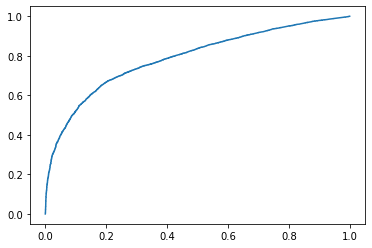

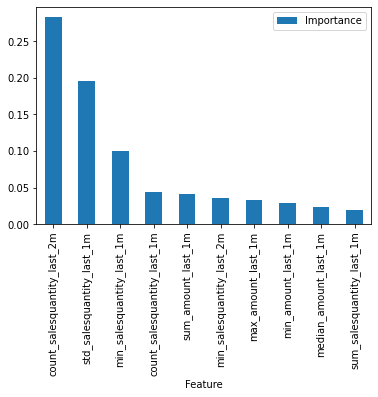

In [11]:
#%%%% Training
dataset = base_all.loc[(base_all.year_month == 201804) | (base_all.year_month == 201803),]
dataset_oot = base_all.loc[(base_all.year_month == 201805),]
dataset = dataset.drop(['csn','year_month','sum_price_last_2m','sum_price_last_1m'], axis=1)
dataset_oot = dataset_oot.drop(['csn','year_month','sum_price_last_2m','sum_price_last_1m'], axis=1)

X_oot = dataset_oot.iloc[:,1:]
y_oot = dataset_oot.iloc[:,0]

X = dataset.iloc[:,1:]
Y = dataset.iloc[:,0]

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit RandomForestClassifier model 
rfc = RandomForestClassifier(max_depth=3,random_state=seed) #overfitting if we dont set max_depth=3
rfc.fit(X_train.fillna(1.1e-20), y_train)

print('=================================================')
print('=================================================')
print('RandomForestClassifier')
print(rfc)
print('=================================================')
print('=================================================')

print('=================================================')
print('=================================================')
print('RandomForestClassifier')
fpr, tpr, thresholds = metrics.roc_curve(y_train, rfc.predict_proba(X_train.fillna(1.1e-20))[:,1])
print('gini_train',2*metrics.auc(fpr, tpr)-1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, rfc.predict_proba(X_test.fillna(1.1e-20))[:,1])
print('gini_test',2*metrics.auc(fpr, tpr)-1)
fpr, tpr, thresholds = metrics.roc_curve(y_oot, rfc.predict_proba(X_oot.fillna(1.1e-20))[:,1])
print('gini_oot',2*metrics.auc(fpr, tpr)-1)
print('=================================================')
print('=================================================')
print('SVC')
# fit SVC model 

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
svc = make_pipeline(StandardScaler(), SVC(probability=True,random_state=seed))

svc.fit(X_train.fillna(0), y_train)
print('=================================================')
print('=================================================')
print('SVC')
print(svc)
print('=================================================')
print('=================================================')

fpr, tpr, thresholds = metrics.roc_curve(y_train, svc.predict_proba(X_train.fillna(0))[:,1])
print('gini_train',2*metrics.auc(fpr, tpr)-1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, svc.predict_proba(X_test.fillna(0))[:,1])
print('gini_test',2*metrics.auc(fpr, tpr)-1)
fpr, tpr, thresholds = metrics.roc_curve(y_oot, svc.predict_proba(X_oot.fillna(0))[:,1])
print('gini_oot',2*metrics.auc(fpr, tpr)-1)



# fit XGBClassifier model 
model = XGBClassifier(random_state=seed,seed=seed)
model.fit(X_train, y_train)

print('=================================================')
print('=================================================')
print('XGBClassifier')
print(model)
print('=================================================')
print('=================================================')
fpr, tpr, thresholds = metrics.roc_curve(y_train, model.predict_proba(X_train)[:,1])
print('gini_train',2*metrics.auc(fpr, tpr)-1)

fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
print('gini_test',2*metrics.auc(fpr, tpr)-1)

fpr, tpr, thresholds = metrics.roc_curve(y_oot, model.predict_proba(X_oot)[:,1])
print('gini_oot',2*metrics.auc(fpr, tpr)-1)

print('=================================================')
print('=================================================')
plt.plot(fpr,tpr)
print('=================================================')
print('=================================================')
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances
print('=================================================')
print('=================================================')
importances[:10].plot.bar()
print('=================================================')
print('=================================================')

**Tuning XGB**

In [22]:
import timeit

start = timeit.default_timer()

from sklearn.model_selection import GridSearchCV

params = {'gamma': [0.1, 1],
          'learning_rate': [0.01, 0.1],
          'max_depth': [3, 5],
        'min_child_weight': [1, 100],
        'n_estimators': [100, 200],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        
        }

gsearch1 = GridSearchCV(estimator = XGBClassifier(objective= 'binary:logistic', nthread=4, random_state=seed,seed=seed), 
 param_grid = params, scoring='roc_auc',n_jobs=-1)

gsearch1.fit(X_train, y_train)
#gsearch1.best_score_, gsearch1.best_params_, gsearch1.best_score_

print('tuned XGBClassifier')
print(gsearch1)
print('=================================================')
print('=================================================')
fpr, tpr, thresholds = metrics.roc_curve(y_train, gsearch1.predict_proba(X_train)[:,1])
print('gini_train',2*metrics.auc(fpr, tpr)-1)

fpr, tpr, thresholds = metrics.roc_curve(y_test, gsearch1.predict_proba(X_test)[:,1])
print('gini_test',2*metrics.auc(fpr, tpr)-1)

fpr, tpr, thresholds = metrics.roc_curve(y_oot, gsearch1.predict_proba(X_oot)[:,1])
print('gini_oot',2*metrics.auc(fpr, tpr)-1)

print('=================================================')
print('=================================================')

stop = timeit.default_timer()

print('Time: ', (stop - start)/60)  

tuned XGBClassifier
GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=7, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=7, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.1, 1],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
               

In [23]:
print(gsearch1.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.1,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=100, missing=None, n_estimators=200, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=7,
              silent=None, subsample=1.0, verbosity=1)


**Final model**

In [27]:

model_final = XGBClassifier(random_state=seed,seed=seed,colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5,
              min_child_weight=100, n_estimators=200, nthread=4, subsample=1.0)
model_final.fit(X_train, y_train)

print('=================================================')
print('=================================================')
print('XGBClassifier')
print(model_final)
print('=================================================')
print('=================================================')
fpr, tpr, thresholds = metrics.roc_curve(y_train, model_final.predict_proba(X_train)[:,1])
print('gini_train',2*metrics.auc(fpr, tpr)-1)

fpr, tpr, thresholds = metrics.roc_curve(y_test, model_final.predict_proba(X_test)[:,1])
print('gini_test',2*metrics.auc(fpr, tpr)-1)

fpr, tpr, thresholds = metrics.roc_curve(y_oot, model_final.predict_proba(X_oot)[:,1])
print('gini_oot',2*metrics.auc(fpr, tpr)-1)

print('=================================================')
print('=================================================')
#plt.plot(fpr,tpr)
print('=================================================')
print('=================================================')
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_final.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances
print('=================================================')
print('=================================================')
#importances[:10].plot.bar()

importances.to_csv('importances.csv')

XGBClassifier
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.1,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=100, missing=None, n_estimators=200, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=7,
              silent=None, subsample=1.0, verbosity=1)
gini_train 0.6131000482529942
gini_test 0.5705837753450251
gini_oot 0.577714888886447


**For reporting and strategy**

In [28]:

output_train = model_final.predict_proba(X_train)[:,1]
output_train = pd.DataFrame({'quantile':output_train})
cutoff = output_train.quantile([0.9, .8, .7, .6, .5, .4, .3, .2, .1])

cutoff = cutoff['quantile'].to_list()
def quantile_dev(x,cutoff):
    if x>=cutoff[0]:
        return 1
    elif x>=cutoff[1]:
        return 2
    elif x>=cutoff[2]:
        return 3
    elif x>=cutoff[3]:
        return 4
    elif x>=cutoff[4]:
        return 5
    elif x>=cutoff[5]:
        return 6
    elif x>=cutoff[6]:
        return 7
    elif x>=cutoff[7]:
        return 8
    elif x>=cutoff[8]:
        return 9
    else: return 10
    
report = pd.DataFrame({'actual':y_oot,'predict':model_final.predict_proba(X_oot)[:,1]})
report['rank'] = report['predict'].apply(lambda a : quantile_dev(a,cutoff))
res = report.groupby(['rank'])['actual', 'predict'].agg([('mean',np.mean),('sum',np.sum), ('count','count')]).reset_index()
    
report = pd.DataFrame({'actual':y_test,'predict':model_final.predict_proba(X_test)[:,1]})
report['rank'] = report['predict'].apply(lambda a : quantile_dev(a,cutoff))
res = report.groupby(['rank'])['actual', 'predict'].agg([('mean',np.mean),('sum',np.sum), ('count','count')]).reset_index()
    
   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
